# Medical Drug Recommender
> Recommending top-k drugs for the given medical condition based on historical feedbacks, using Neural Collaborative Filtering model

- toc: true
- badges: true
- comments: true
- categories: [NCF, Keras, Healthcare, Kaggle]
- image:

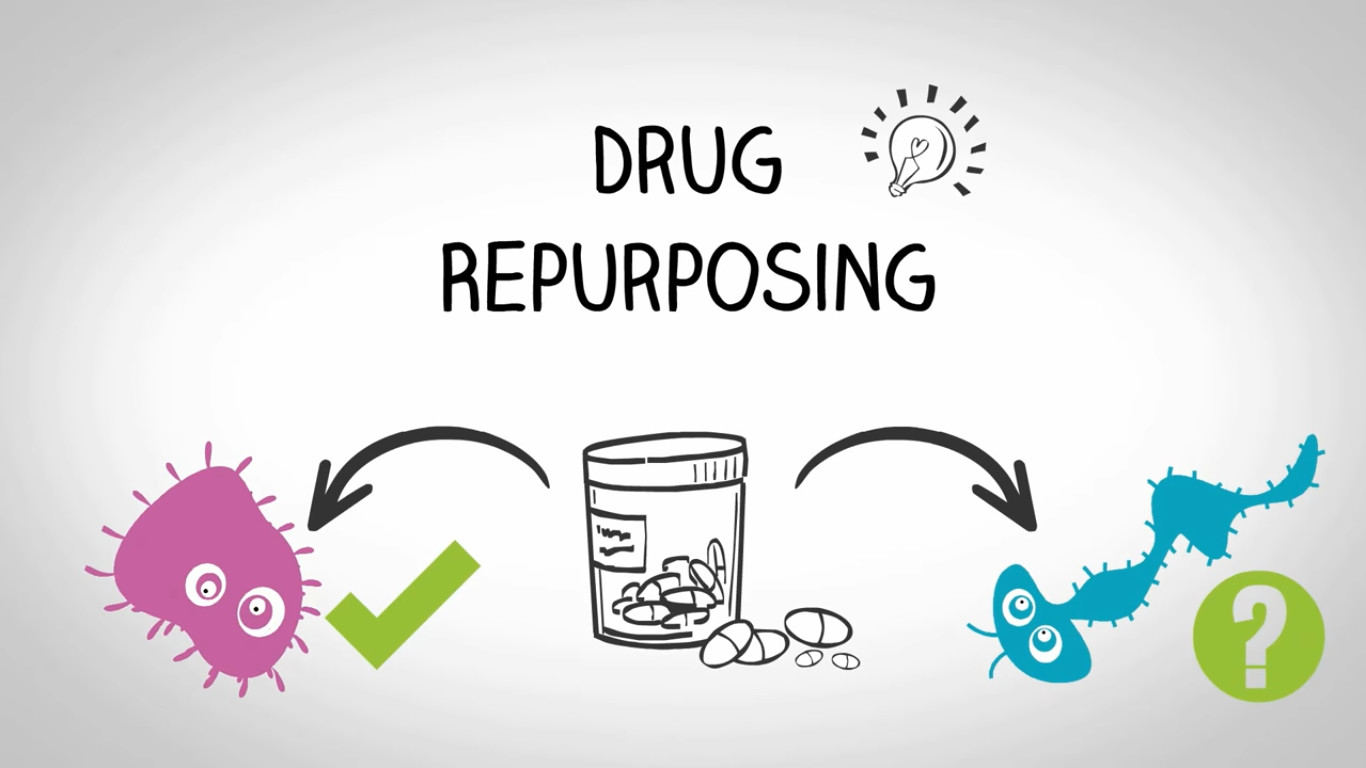

### Introduction

Machine learning can be used in all aspects of human life, New Drug discovery can be very expensive and can take up to a year, Hence it is very beneficial to find the drug that can be used to treat the specific medical condition from the existing drugs.

The development of a new drug is a tedious, costly, and time-consuming process. Drug repurposing is intended to find alternative uses for a pioneering drug . AI-empowered drug repurposing is a cheaper, faster, and effective approach and can reduce the failures in clinical trials.AI-based Deep learning models can predict drug structures that could potentially treat COVID-19.

With an increase in technology, the information/data about drugs is increasing Data is available for the research  ( eg Drug bank ), Medical researchers around the globe are using this data for various purposes.

With the help of AI and ML techniques, we can find the correlation between different drugs and medical conditions(Recommendation systems), and using this relation we can suggest few drugs that can help in the treatment of the specific medical condition thereby helping the medical researchers and institutions to get the results more quickly and efficiently.

This idea is similar to the idea of recommendation systems where the item is recommended to the user based on certain factors

Similarly, we can recommend the drug for the treatment of certain medical conditions based on certain factors.

To do so, here we are using the Nural collaborative filtering approach to predict the drugs for a specific medical condition. We will be using the Multilayer perceptron model.

### Environment setup

In [ ]:
# !pip install -q -U kaggle
# !pip install --upgrade --force-reinstall --no-deps kaggle
# !mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d jessicali9530/kuc-hackathon-winter-2018
# !unzip kuc-hackathon-winter-2018.zip

In [12]:
import sys 
import multiprocessing
from time import time

import numpy as np
import pandas as pd
import random
import math
import argparse
import heapq
import scipy.sparse as sp
from sklearn.preprocessing import LabelEncoder

import theano
import theano.tensor as T
import tensorflow as tf
import keras

from keras import layers
from keras.models import Sequential,Model
from keras import backend as K
from keras import initializers
from keras.regularizers import l1, l2 
from keras.layers import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, merge ,Reshape, Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop

### Data loading

In [8]:
df = pd.read_csv('/content/drugsComTrain_raw.csv')
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [11]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
uniqueID,161297,NaN,NaN,NaN,115924,67004.4,2,58063,115744,173776,232291
drugName,161297,3436,Levonorgestrel,3657,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,160398,884,Birth Control,28788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review,161297,112329,"""Good""",33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,161297,NaN,NaN,NaN,6.99438,3.27233,1,5,8,10,10
date,161297,3579,1-Mar-16,146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usefulCount,161297,NaN,NaN,NaN,28.0048,36.4037,0,6,16,36,1291


### Data pre-processing

In [ ]:
le_drug = LabelEncoder()
le_condition = LabelEncoder()

n_condition = 0 # number of conditions
n_drugs = 0 # number of drugs

In [83]:
def preprocessing(data, test=False):
    # selecting only usefule columns
    data = data[['condition','drugName','usefulCount']]

    # condition column has some missing values - filling with 'NA'
    data['condition'] = data['condition'].fillna('NA')

    # label encoding
    if test:
        data['condition'] = le_condition.transform(data['condition'])
        data['drugName'] = le_drug.transform(data['drugName'])
    else:
        data['condition'] = le_condition.fit_transform(data['condition'])
        data['drugName'] = le_drug.fit_transform(data['drugName'])
    
    # train set -> sparse matrix
    global n_condition
    global n_drugs
    n_condition = data.condition.nunique()
    n_drugs = data.drugName.nunique()
    train = sp.dok_matrix((n_condition, n_drugs), dtype=np.float32)
    for i in range(len(data['condition'])):
        ls = list(data.iloc[i])
        train[ls[0],ls[1]] = 1.0

    # test set - taking 200 random interactions
    test = []
    for j in range(200):
        i = random.randint(0, len(data))
        ls = list(data.iloc[i])
        test.append([ls[0],ls[1]])

    return train, test

In [84]:
train, test = preprocessing(df)
train

<885x3436 sparse matrix of type '<class 'numpy.float32'>'
	with 8748 stored elements in Dictionary Of Keys format>

### Evaluation methods
To evaluate the performance of drug recommendation, we adopted the leave-one-out evaluation.

HR intuitively measures whether the test item is present on the top-10 list, and the NDCG accounts for the position of the hit by assigning higher scores to hits at top ranks. We will calculate both metrics for each test user and asssine the average score.

In [23]:
def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

In [93]:
def evaluate(train, test, model, K):

  HR, NDCG = [],[]

  for i in range(len(test)):                                              
    rating = test[i]                                                     
    u = rating[0]  

    # taking 99 random untested conditions by that drug
    count = 0
    drugs = [] 
    while(count != 99):
      j = random.randint(0, n_drugs-1)     
      if (u,j) in train.keys():
        continue
      drugs.append(j)
      count+=1                                                                      
    gtdrug = rating[1]                                                     
    drugs.append(gtdrug)                                                   
    
    # Get prediction scores
    map_drug_score = {}
    medical_conditions = np.full(len(drugs), u, dtype = 'int32')
    predictions = model.predict([medical_conditions, np.array(drugs)], 
                                 batch_size=64, verbose=0)               
    
    for i in range(len(drugs)):                                            
        drug = drugs[i]
        map_drug_score[drug] = predictions[i]
    drugs.pop()                                                             
    
    ranklist = heapq.nlargest(K, map_drug_score, key=map_drug_score.get)   
    hr = getHitRatio(ranklist, gtdrug)                                       
    ndcg = getNDCG(ranklist, gtdrug)

    HR.append(hr)
    NDCG.append(ndcg) 

  return (HR, NDCG)

### Model build

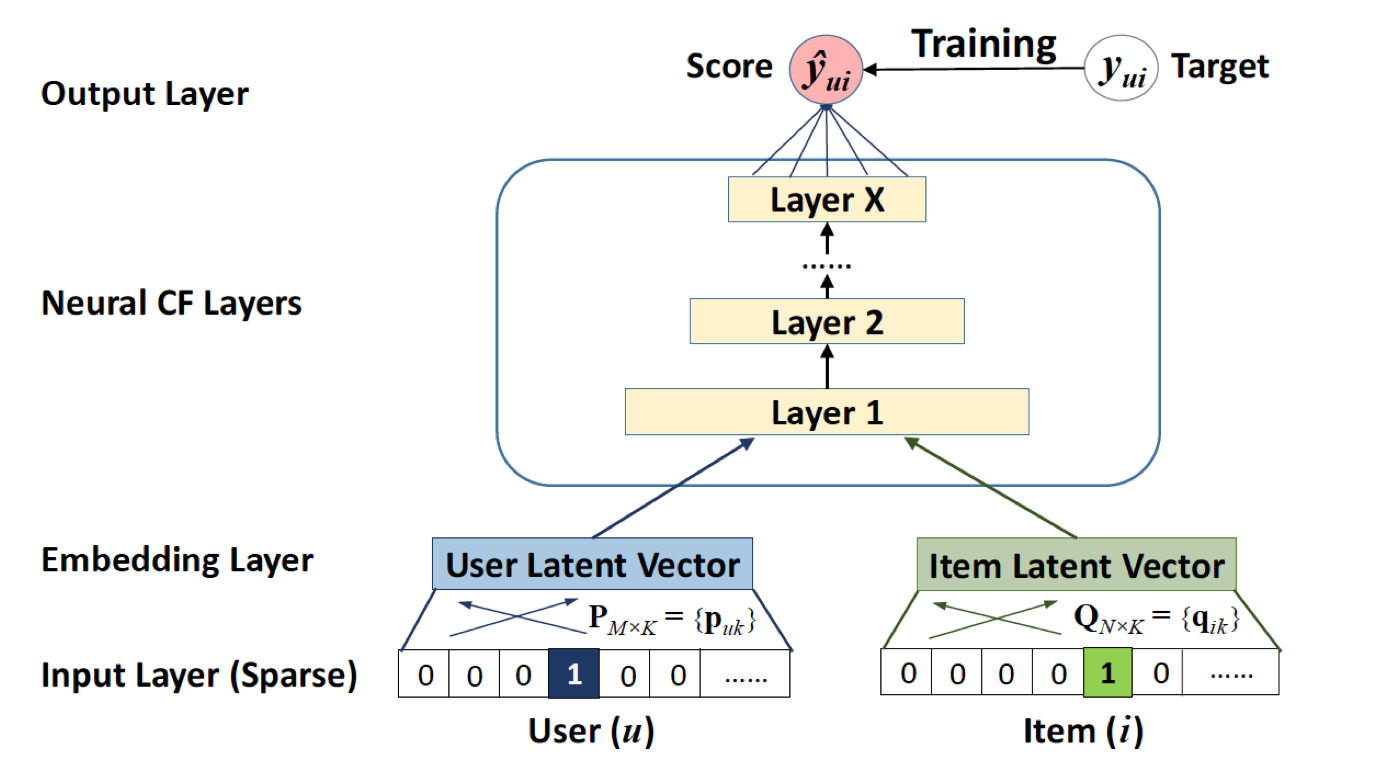

In [94]:
def get_model(num_medical_conditions, num_drugs, layers = [16,8], reg_layers=[0,0]):

    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    medical_condition_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    drug_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MLP_Embedding_Medical_Conditions = Embedding(input_dim = num_medical_conditions, output_dim = int(layers[0]/2), 
                                   name = 'medical_condition_embedding', input_length=1)
    MLP_Embedding_Drugs = Embedding(input_dim = num_drugs, output_dim = int(layers[0]/2), 
                                   name = 'drug_embedding', input_length=1)   
    
    medical_condition_latent = Flatten()(MLP_Embedding_Medical_Conditions(medical_condition_input)) # flattening embedding for user 
    drug_latent = Flatten()(MLP_Embedding_Drugs(drug_input)) # flattening embedding for items
    vector = keras.layers.concatenate([medical_condition_latent,drug_latent]) # forming the 0th layer of NN by concatinating the user and items flatten layer 
    
    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]), activation='relu', name = 'layer%d' %idx)
        vector = layer(vector)
        #layer1 = Dropout(0.25)
        #vector = layer1(vector)
        
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(vector)
    model = Model(inputs=[medical_condition_input, drug_input],
                  outputs=prediction)
    
    return model

In [95]:
def get_train_instances(train, num_negatives):
  
    medical_condition_input, drug_input, labels = [],[],[]
    num_medical_conditions = train.shape[0]

    for (u, i) in train.keys():

        # positive instance
        medical_condition_input.append(u)
        drug_input.append(i)
        labels.append(1) # 1 for positive instance

        # negative instances
        for t in range(num_negatives):
            j = np.random.randint(num_drugs)
            while ( (u,j) in train.keys() ) :
                j = np.random.randint(num_drugs)
            medical_condition_input.append(u)
            drug_input.append(j)
            labels.append(0) # 0 for negative instance
        
    return medical_condition_input, drug_input, labels

### Model training and evaluation

In [96]:
path = '/content'
layers = [256,128,64,32,16,8]
reg_layers = [0,0,0,0,0,0]
num_negatives =  6
learner =  'adam'
learning_rate = 0.001
batch_size = 256
epochs = 5
verbose = 1

topK = 3
model_out_file = 'Pretrain_new.h5'  

In [97]:
num_medical_conditions, num_drugs = train.shape

# Build model
model = get_model(num_medical_conditions, num_drugs, layers, reg_layers)

#compile model
model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy',metrics=['accuracy'])

# Check Init performance
t1 = time()
(hr, ndcg) = evaluate(train, test, model,topK)
HR, NDCG = np.array(hr).mean(), np.array(ndcg).mean()
print('Init: HR = %.4f, NDCG = %.4f [%.1f]' %(HR, NDCG, time()-t1))

Init: HR = 0.0250, NDCG = 0.0182 [10.8]


In [98]:
# Train model
best_hr, best_ndcg, best_iter = HR, NDCG, -1

for epoch in range(epochs):
    t1 = time()

    # Generate training instances
    medical_condition_input, drug_input, labels = get_train_instances(train, num_negatives)

    # Training        
    hist = model.fit([np.array(medical_condition_input), np.array(drug_input)],
                        np.array(labels),batch_size=batch_size, epochs=20, verbose=0, shuffle=True)
    
    t2 = time()

    # Evaluation
    if epoch %verbose == 0:

        (hr, ndcg) = evaluate(train, test, model, topK)
        HR, NDCG, loss = np.array(hr).mean(), np.array(ndcg).mean(), hist.history['loss'][0]
        print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
                % (epoch,  t2-t1, HR, NDCG, loss, time()-t2))
        
        if HR >= best_hr and NDCG >= best_ndcg:

            best_hr, best_ndcg, best_iter = HR, NDCG, epoch
            model.save(model_out_file)

print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))
print("The best MLP model is saved to %s" %(model_out_file))

Iteration 0 [42.3 s]: HR = 0.9300, NDCG = 0.8540, loss = 0.4361 [10.3 s]
Iteration 1 [42.8 s]: HR = 0.9750, NDCG = 0.9021, loss = 0.0968 [10.5 s]
Iteration 2 [42.4 s]: HR = 1.0000, NDCG = 0.9698, loss = 0.0660 [10.7 s]
Iteration 3 [41.6 s]: HR = 1.0000, NDCG = 0.9680, loss = 0.0443 [10.2 s]
Iteration 4 [42.0 s]: HR = 1.0000, NDCG = 0.9797, loss = 0.0345 [10.2 s]
End. Best Iteration 4:  HR = 1.0000, NDCG = 0.9797. 
The best MLP model is saved to Pretrain_new.h5


### Inference

In [100]:
Best_model = tf.keras.models.load_model('/content/Pretrain_new.h5', compile = True)

In [107]:
def recommend(condition_name='Influenza Prophylaxis', topk=3):

    drugs = [i for i in range(n_drugs)]
    condition_id = le_condition.transform([condition_name])[0]
    medical_conditions = np.full(len(drugs), condition_id, dtype = 'int32')
    predictions = Best_model.predict([medical_conditions, np.array(drugs)], 
                                    batch_size=100, verbose=0)

    map_drug_score ={}
    for i in range(len(drugs)): # creating the{ item : chance } dict 
            drug = drugs[i]
            map_drug_score[drug] = predictions[i]

    ranklist = heapq.nlargest(topk, map_drug_score, key=map_drug_score.get)
    print("{} can be treated by: ".format(condition_name))
    for i in ranklist:
        print("\n\t"+le_drug.inverse_transform([i])[0])

Let’s select some random medical conditions and recommendations drugs to cure these conditions.

In [68]:
conditions_random3 = np.random.choice(le_condition.classes_, 3)
conditions_random3

array(['ibromyalgia', 'Influenza Prophylaxis',
       'Benign Prostatic Hyperplasia'], dtype=object)

**Fibromyalgia**

> Note: I think first letter is 'F' and it is missing from the condition name. We will continue our inference journey by assuming it is `Fibromyalgia`.

*Fibromyalgia is a disorder characterized by widespread musculoskeletal pain accompanied by fatigue, sleep, memory and mood issues. Researchers believe that fibromyalgia amplifies painful sensations by affecting the way your brain and spinal cord process painful and nonpainful signals.*

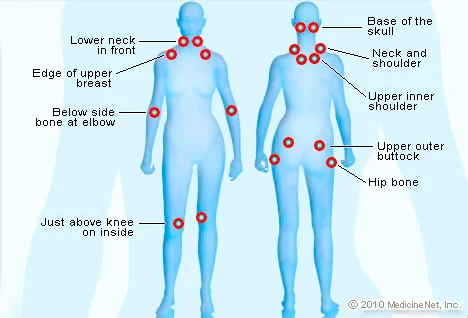

In [108]:
recommend(conditions_random3[0])

ibromyalgia can be treated by: 

	Amrix

	Cymbalta

	Gabapentin


**Influenza**

*Influenza is a viral infection that attacks your respiratory system — your nose, throat and lungs. Influenza is commonly called the flu, but it's not the same as stomach "flu" viruses that cause diarrhea and vomiting. For most people, the flu resolves on its own.*

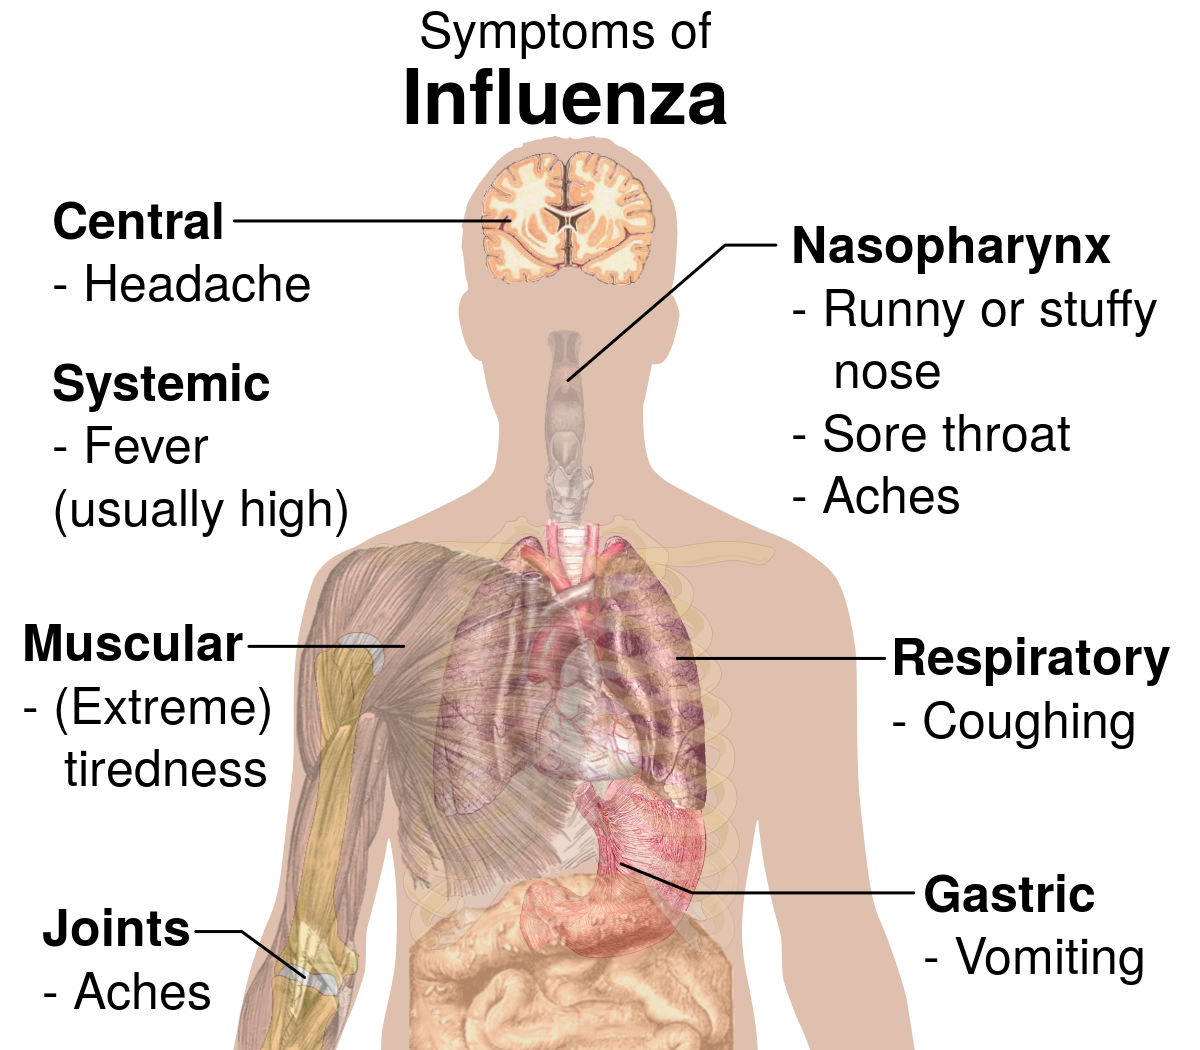

In [109]:
recommend(conditions_random3[1])

Influenza Prophylaxis can be treated by: 

	Influenza virus vaccine, live, trivalent

	Oseltamivir

	Mysoline


**Benign Prostatic Hyperplasia**

*Age-associated prostate gland enlargement that can cause urination difficulty.
This type of prostate enlargement isn't thought to be a precursor to prostate cancer. With this condition, the urinary stream may be weak or stop and start. In some cases, it can lead to infection, bladder stones and reduced kidney function. Treatments include medication that relaxes or shrinks the prostate, surgery and minimally invasive surgery.*

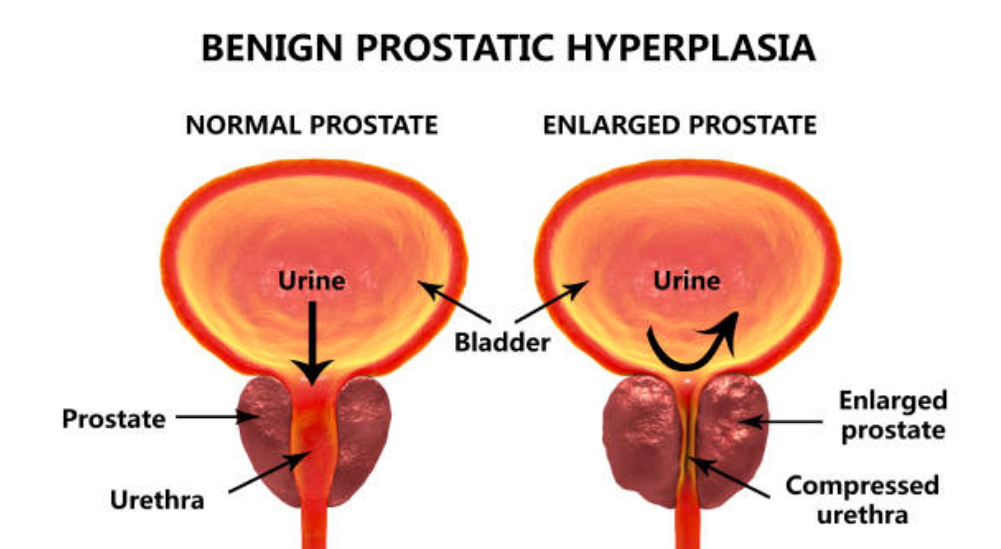

In [110]:
recommend(conditions_random3[2])

Benign Prostatic Hyperplasia can be treated by: 

	Dutasteride / tamsulosin

	Hytrin

	Terazosin


### References
1. https://github.com/mankar1257/Drug-Prediction-using-neural-collaborative-filtering `repo`
2. https://medium.com/analytics-vidhya/neural-collaborative-filtering-for-drug-prediction-e8d0c552317b `blog`

### Further improvements

This was the basic model for drug prediction. Modification can be done to learn some more complex relations:
1. We can consider the features of the drug ( like protein structure, activity in different environments… )
2. the large data set can also help to increase the radius of the possibilities and can lead to better predictions
3. using more deep NN structure
4. fine-tuning the hyperparameters